# `Project : Product recommendation based on visual similarity`
### scope
*   Input : đầu vào một ảnh sản phẩm bất kì
*   Output : gợi ý 5 hình ảnh sản phẩm tương tự 

### Model 

*   CNN
*   Vggg-16

### Using TensorFlow backend.
### Các bước tiến hành 


1.   Sử dụng một mô hình CNN được đào tạo trước từ Keras để trích xuất các đặc điểm hình ảnh.
2.   Sau đó, tính toán sự tương đồng giữa các sản phẩm khác nhau bằng cách sử dụng các tính năng hình ảnh được trích xuất trước đó.



# **`CODE`**

1. Thêm các thư viện,thiết lập các tham số đường dẫn.




In [4]:
from keras.applications import vgg16
# from keras.preprocessing.image import load_img,img_to_array
from tensorflow.keras.preprocessing.image import load_img
from keras.models import Model
from keras.applications.imagenet_utils import preprocess_input

from PIL import Image
import os,keras
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd
from tensorflow.keras.utils import load_img,img_to_array
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D , Flatten
from keras.optimizers import Adam

In [5]:
imgs_path = r"D:\Code\Project\ML_ProductRecommendation\Data\Images\img_trains"

imgs_model_width, imgs_model_height = 224, 224

nb_closest_images = 5 # number of most similar images to retrieve

2. 

In [6]:
# load the model
vgg_model = vgg16.VGG16(weights='imagenet')

# remove the last layers in order to get features instead of predictions
feat_extractor = Model(inputs=vgg_model.input, outputs=vgg_model.get_layer("fc2").output)

# print the layers of the CNN
feat_extractor.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [8]:
def vgg_16():

  model = Sequential()
  model.add(Conv2D(input_shape=(224,224,3),filters=64,kernel_size=(3,3),padding="same", activation="relu"))
  model.add(Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu"))
  model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
  model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
  model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
  model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
  model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
  model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
  model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
  model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
  model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
  model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
  model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
  model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
  model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
  model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
  model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
  model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))

  # kích hoạt relu (Rectified Linear Unit) cho mỗi lớp để tất cả các giá trị âm không được chuyển sang lớp tiếp theo.
  model.add(Flatten())
  model.add(Dense(units=4096,activation="relu"))
  model.add(Dense(units=4096,activation="relu"))
  # Lớp softmax sẽ xuất ra giá trị từ 0 đến 1 dựa trên độ tin cậy của mô hình mà hình ảnh thuộc lớp nào.
  # model.add(Dense(units=2, activation="softmax"))
 
  opt = Adam(lr=0.001)
  model.compile(optimizer=opt, loss=keras.losses.categorical_crossentropy, metrics=['accuracy'])
  return model

In [9]:
vgg_16().summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 64)      1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 224, 224, 64)      36928     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 64)     0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 112, 112, 128)     73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 112, 112, 128)     147584    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 128)      0         
 2D)                                                    

d:\Code\Project\ML_ProductRecommendation\recommendvenv\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


3. Lấy các đường dẫn hình ảnh

In [7]:
files = [imgs_path+'//' + x for x in os.listdir(imgs_path) if "png" in x]

print("number of images:",len(files))

number of images: 925


In [8]:
files

['D:\\Code\\Project\\ML_ProductRecommendation\\Data\\Images\\img_trains//Baseball_caps1_10.png',
 'D:\\Code\\Project\\ML_ProductRecommendation\\Data\\Images\\img_trains//Baseball_caps1_11.png',
 'D:\\Code\\Project\\ML_ProductRecommendation\\Data\\Images\\img_trains//Baseball_caps1_13.png',
 'D:\\Code\\Project\\ML_ProductRecommendation\\Data\\Images\\img_trains//Baseball_caps1_14.png',
 'D:\\Code\\Project\\ML_ProductRecommendation\\Data\\Images\\img_trains//Baseball_caps1_16.png',
 'D:\\Code\\Project\\ML_ProductRecommendation\\Data\\Images\\img_trains//Baseball_caps1_17.png',
 'D:\\Code\\Project\\ML_ProductRecommendation\\Data\\Images\\img_trains//Baseball_caps1_21.png',
 'D:\\Code\\Project\\ML_ProductRecommendation\\Data\\Images\\img_trains//Baseball_caps1_22.png',
 'D:\\Code\\Project\\ML_ProductRecommendation\\Data\\Images\\img_trains//Baseball_caps1_23.png',
 'D:\\Code\\Project\\ML_ProductRecommendation\\Data\\Images\\img_trains//Baseball_caps1_24.png',
 'D:\\Code\\Project\\ML_Produc

4. Đưa một hình ảnh vào CNN

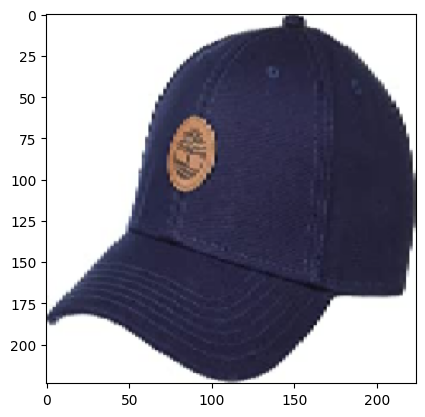

image loaded successfully!


In [28]:
# load an image in PIL format
original = load_img(files[1], target_size=(imgs_model_width, imgs_model_height))
plt.imshow(original)
plt.show()
print("image loaded successfully!")

In [29]:
# Chuyển PIL thành numpy array
print()
numpy_image = img_to_array(original)
print(numpy_image)
image_batch = np.expand_dims(numpy_image, axis=0)
print('image batch size', image_batch.shape)


[[[255. 255. 255.]
  [255. 255. 255.]
  [255. 255. 255.]
  ...
  [255. 255. 255.]
  [255. 255. 255.]
  [255. 255. 255.]]

 [[255. 255. 255.]
  [255. 255. 255.]
  [255. 255. 255.]
  ...
  [255. 255. 255.]
  [255. 255. 255.]
  [255. 255. 255.]]

 [[255. 255. 255.]
  [255. 255. 255.]
  [255. 255. 255.]
  ...
  [255. 255. 255.]
  [255. 255. 255.]
  [255. 255. 255.]]

 ...

 [[255. 255. 255.]
  [255. 255. 255.]
  [255. 255. 255.]
  ...
  [255. 255. 255.]
  [255. 255. 255.]
  [255. 255. 255.]]

 [[255. 255. 255.]
  [255. 255. 255.]
  [255. 255. 255.]
  ...
  [255. 255. 255.]
  [255. 255. 255.]
  [255. 255. 255.]]

 [[255. 255. 255.]
  [255. 255. 255.]
  [255. 255. 255.]
  ...
  [255. 255. 255.]
  [255. 255. 255.]
  [255. 255. 255.]]]
image batch size (1, 224, 224, 3)


In [30]:
# Chuẩn bị ảnh cho model vgg16
processed_image = preprocess_input(image_batch.copy())
# get the extracted features
img_features = feat_extractor.predict(processed_image)

print("features successfully extracted!")
print("number of image features:",img_features.size)
img_features


1/1 [==============================] - 1s 897ms/step
features successfully extracted!
number of image features: 4096


array([[0.       , 0.       , 0.       , ..., 5.2012115, 0.       ,
        0.       ]], dtype=float32)

5. Đưa tất cả hình ảnh vào CNN

In [12]:
#tải tất cả các hình ảnh và chuẩn bị cho chúng để đưa vào CNN
importedImages = []

for f in files:
    filename = f
    original = load_img(filename, target_size=(224, 224))
    numpy_image = img_to_array(original)
    image_batch = np.expand_dims(numpy_image, axis=0)
    
    importedImages.append(image_batch)
    
images = np.vstack(importedImages)

processed_imgs = preprocess_input(images.copy())

In [39]:
# extract the images features

imgs_features = feat_extractor.predict(processed_imgs)

print("features successfully extracted!")
imgs_features.shape

29/29 [==============================] - 85s 3s/step
features successfully extracted!


(925, 4096)

In [52]:
results = []
for i,file in zip(imgs_features,files) :
  print(i)

[0.        0.        0.        ... 2.4876368 0.        0.       ]
[0.      0.      0.      ... 5.20121 0.      0.     ]
[0.        0.        0.        ... 1.1062715 0.        0.       ]
[0.         0.         0.         ... 1.7673385  0.         0.40632147]
[0.         0.         0.         ... 3.9337533  0.1379033  0.11796337]
[0.        0.        0.        ... 3.774985  1.9108441 0.       ]
[0.        0.        1.0696703 ... 2.9269145 0.        0.       ]
[0.        0.        0.        ... 2.8122685 2.0544379 0.       ]
[0.         0.         0.         ... 2.3058765  0.43247986 0.        ]
[0.       0.       0.       ... 5.057493 0.       0.      ]
[0.       0.       0.       ... 4.286591 0.       0.      ]
[0.         0.         0.         ... 1.9740217  0.83667195 0.        ]
[0.        0.        0.        ... 4.2678566 0.        0.       ]
[0.         0.         0.         ... 2.0462544  0.53362745 0.        ]
[0.        0.        0.0050624 ... 1.1897066 2.5595    0.       ]
[0. 

In [56]:
df = pd.DataFrame(imgs_features, index=files)
df.to_csv(r'D:\Code\Project\ML_ProductRecommendation\Data\model\model2.csv')

In [62]:
df_2 = pd.read_csv('D:\Code\Project\ML_ProductRecommendation\Data\model\model2.csv')
B = (df_2.iloc[0:,1:]).to_numpy()

In [63]:
from numpy.linalg import norm

# define two lists or array
A = img_features


for b,file in zip(B,files) :
# compute cosine similarity
  cosine = np.dot(A,b)/(norm(A)*norm(b))
#   print("Cosine Similarity:", cosine)
  if(cosine > 0.85 and cosine < 1.0) :
    print('hong tuoi xinh dep',cosine,file)

hong tuoi xinh dep [0.87655415] D:\Code\Project\ML_ProductRecommendation\Data\Images\img_trains//Baseball_caps2_7.png
hong tuoi xinh dep [0.86980914] D:\Code\Project\ML_ProductRecommendation\Data\Images\img_trains//Baseball_caps4_40.png


In [17]:
# compute cosine similarities between images

cosSimilarities = cosine_similarity(imgs_features)

# store the results into a pandas dataframe

cos_similarities_df = pd.DataFrame(cosSimilarities, columns=files, index=files)
cos_similarities_df.head()

,0,1,2,3,4,5,6,7,8,9,...,915,916,917,918,919,920,921,922,923,924
D:\Code\Project\ML_ProductRecommendation\Data\Images\img_trains//Baseball_caps1_10.png,1.000000,0.787996,0.763684,0.644765,0.740488,0.631481,0.587865,0.698676,0.776426,0.781976,...,0.449680,0.341638,0.419893,0.385075,0.260310,0.400685,0.351830,0.412086,0.290475,0.517805
D:\Code\Project\ML_ProductRecommendation\Data\Images\img_trains//Baseball_caps1_11.png,0.787996,1.000000,0.843391,0.698653,0.802340,0.780965,0.648253,0.783696,0.748557,0.790521,...,0.421563,0.438957,0.449024,0.376746,0.302631,0.379084,0.390029,0.441833,0.315794,0.546477
D:\Code\Project\ML_ProductRecommendation\Data\Images\img_trains//Baseball_caps1_13.png,0.763684,0.843391,1.000000,0.655746,0.699484,0.755014,0.705850,0.741908,0.696894,0.775426,...,0.413129,0.426510,0.464229,0.363186,0.309681,0.379584,0.390869,0.446044,0.315048,0.517539
D:\Code\Project\ML_ProductRecommendation\Data\Images\img_trains//Baseball_caps1_14.png,0.644765,0.698653,0.655746,1.000000,0.699185,0.559090,0.606869,0.616457,0.595807,0.587277,...,0.294302,0.295945,0.349586,0.270819,0.227311,0.270962,0.295176,0.389237,0.299834,0.426720
D:\Code\Project\ML_ProductRecommendation\Data\Images\img_trains//Baseball_caps1_16.png,0.740488,0.802340,0.699484,0.699185,1.000000,0.700666,0.551425,0.682044,0.644747,0.745271,...,0.429208,0.354065,0.446161,0.362447,0.275545,0.437551,0.347815,0.397661,0.260939,0.515421


In [53]:
cosSimilarities

array([[0.99999976, 0.7879963 , 0.7636839 , ..., 0.41208637, 0.29047462,
        0.5178054 ],
       [0.7879963 , 1.0000001 , 0.84339076, ..., 0.44183338, 0.31579357,
        0.54647684],
       [0.7636839 , 0.84339076, 1.0000001 , ..., 0.4460443 , 0.31504774,
        0.5175389 ],
       ...,
       [0.41208637, 0.44183338, 0.4460443 , ..., 1.        , 0.41130632,
        0.5029654 ],
       [0.29047462, 0.31579357, 0.31504774, ..., 0.41130632, 1.0000001 ,
        0.44062626],
       [0.5178054 , 0.54647684, 0.5175389 , ..., 0.5029654 , 0.44062626,
        0.9999999 ]], dtype=float32)

6. 

In [14]:
# compute cosine similarities between images

cosSimilarities = cosine_similarity(imgs_features)

# store the results into a pandas dataframe

cos_similarities_df = pd.DataFrame(cosSimilarities, columns=files, index=files)
cos_similarities_df.head()

,D:\Code\Project\ML_ProductRecommendation\Data\Images\img_trains//Baseball_caps1_10.png,D:\Code\Project\ML_ProductRecommendation\Data\Images\img_trains//Baseball_caps1_11.png,D:\Code\Project\ML_ProductRecommendation\Data\Images\img_trains//Baseball_caps1_13.png,D:\Code\Project\ML_ProductRecommendation\Data\Images\img_trains//Baseball_caps1_14.png,D:\Code\Project\ML_ProductRecommendation\Data\Images\img_trains//Baseball_caps1_16.png,D:\Code\Project\ML_ProductRecommendation\Data\Images\img_trains//Baseball_caps1_17.png,D:\Code\Project\ML_ProductRecommendation\Data\Images\img_trains//Baseball_caps1_21.png,D:\Code\Project\ML_ProductRecommendation\Data\Images\img_trains//Baseball_caps1_22.png,D:\Code\Project\ML_ProductRecommendation\Data\Images\img_trains//Baseball_caps1_23.png,D:\Code\Project\ML_ProductRecommendation\Data\Images\img_trains//Baseball_caps1_24.png,...,D:\Code\Project\ML_ProductRecommendation\Data\Images\img_trains//Windbreaker6_16.png,D:\Code\Project\ML_ProductRecommendation\Data\Images\img_trains//Windbreaker6_22.png,D:\Code\Project\ML_ProductRecommendation\Data\Images\img_trains//Windbreaker6_23.png,D:\Code\Project\ML_ProductRecommendation\Data\Images\img_trains//Windbreaker6_24.png,D:\Code\Project\ML_ProductRecommendation\Data\Images\img_trains//Windbreaker6_25.png,D:\Code\Project\ML_ProductRecommendation\Data\Images\img_trains//Windbreaker6_28.png,D:\Code\Project\ML_ProductRecommendation\Data\Images\img_trains//Windbreaker6_6.png,D:\Code\Project\ML_ProductRecommendation\Data\Images\img_trains//Windbreaker6_7.png,D:\Code\Project\ML_ProductRecommendation\Data\Images\img_trains//Windbreaker6_8.png,D:\Code\Project\ML_ProductRecommendation\Data\Images\img_trains//Windbreaker6_9.png
D:\Code\Project\ML_ProductRecommendation\Data\Images\img_trains//Baseball_caps1_10.png,1.000000,0.787996,0.763684,0.644765,0.740488,0.631481,0.587865,0.698676,0.776426,0.781976,...,0.449680,0.341638,0.419893,0.385075,0.260310,0.400685,0.351830,0.412086,0.290475,0.517805
D:\Code\Project\ML_ProductRecommendation\Data\Images\img_trains//Baseball_caps1_11.png,0.787996,1.000000,0.843391,0.698653,0.802340,0.780965,0.648253,0.783696,0.748557,0.790521,...,0.421563,0.438957,0.449024,0.376746,0.302631,0.379084,0.390029,0.441833,0.315794,0.546477
D:\Code\Project\ML_ProductRecommendation\Data\Images\img_trains//Baseball_caps1_13.png,0.763684,0.843391,1.000000,0.655746,0.699484,0.755014,0.705850,0.741908,0.696894,0.775426,...,0.413129,0.426510,0.464229,0.363186,0.309681,0.379584,0.390869,0.446044,0.315048,0.517539
D:\Code\Project\ML_ProductRecommendation\Data\Images\img_trains//Baseball_caps1_14.png,0.644765,0.698653,0.655746,1.000000,0.699185,0.559090,0.606869,0.616457,0.595807,0.587277,...,0.294302,0.295945,0.349586,0.270819,0.227311,0.270962,0.295176,0.389237,0.299834,0.426720
D:\Code\Project\ML_ProductRecommendation\Data\Images\img_trains//Baseball_caps1_16.png,0.740488,0.802340,0.699484,0.699185,1.000000,0.700666,0.551425,0.682044,0.644747,0.745271,...,0.429208,0.354065,0.446161,0.362447,0.275545,0.437551,0.347815,0.397661,0.260939,0.515421


In [47]:
cosSimilarities

array([[0.99999976, 0.7879963 , 0.7636839 , ..., 0.41208637, 0.29047462,
        0.5178054 ],
       [0.7879963 , 1.0000001 , 0.84339076, ..., 0.44183338, 0.31579357,
        0.54647684],
       [0.7636839 , 0.84339076, 1.0000001 , ..., 0.4460443 , 0.31504774,
        0.5175389 ],
       ...,
       [0.41208637, 0.44183338, 0.4460443 , ..., 1.        , 0.41130632,
        0.5029654 ],
       [0.29047462, 0.31579357, 0.31504774, ..., 0.41130632, 1.0000001 ,
        0.44062626],
       [0.5178054 , 0.54647684, 0.5175389 , ..., 0.5029654 , 0.44062626,
        0.9999999 ]], dtype=float32)

6. Lưu model vào file csv

In [30]:
cos_similarities_df.to_csv(r'D:\Code\Project\ML_ProductRecommendation\Data\model\model.csv')


In [31]:
df = pd.read_csv('D:\Code\Project\ML_ProductRecommendation\Data\model\model.csv')
df.head()

,Unnamed: 0,D:\Code\Project\ML_ProductRecommendation\Data\Images\img_trains//Baseball_caps1_10.png,D:\Code\Project\ML_ProductRecommendation\Data\Images\img_trains//Baseball_caps1_11.png,D:\Code\Project\ML_ProductRecommendation\Data\Images\img_trains//Baseball_caps1_13.png,D:\Code\Project\ML_ProductRecommendation\Data\Images\img_trains//Baseball_caps1_14.png,D:\Code\Project\ML_ProductRecommendation\Data\Images\img_trains//Baseball_caps1_16.png,D:\Code\Project\ML_ProductRecommendation\Data\Images\img_trains//Baseball_caps1_17.png,D:\Code\Project\ML_ProductRecommendation\Data\Images\img_trains//Baseball_caps1_21.png,D:\Code\Project\ML_ProductRecommendation\Data\Images\img_trains//Baseball_caps1_22.png,D:\Code\Project\ML_ProductRecommendation\Data\Images\img_trains//Baseball_caps1_23.png,...,D:\Code\Project\ML_ProductRecommendation\Data\Images\img_trains//Windbreaker6_16.png,D:\Code\Project\ML_ProductRecommendation\Data\Images\img_trains//Windbreaker6_22.png,D:\Code\Project\ML_ProductRecommendation\Data\Images\img_trains//Windbreaker6_23.png,D:\Code\Project\ML_ProductRecommendation\Data\Images\img_trains//Windbreaker6_24.png,D:\Code\Project\ML_ProductRecommendation\Data\Images\img_trains//Windbreaker6_25.png,D:\Code\Project\ML_ProductRecommendation\Data\Images\img_trains//Windbreaker6_28.png,D:\Code\Project\ML_ProductRecommendation\Data\Images\img_trains//Windbreaker6_6.png,D:\Code\Project\ML_ProductRecommendation\Data\Images\img_trains//Windbreaker6_7.png,D:\Code\Project\ML_ProductRecommendation\Data\Images\img_trains//Windbreaker6_8.png,D:\Code\Project\ML_ProductRecommendation\Data\Images\img_trains//Windbreaker6_9.png
0,D:\Code\Project\ML_ProductRecommendation\Data\...,1.000000,0.787996,0.763684,0.644765,0.740488,0.631481,0.587865,0.698676,0.776426,...,0.449680,0.341638,0.419893,0.385075,0.260310,0.400685,0.351830,0.412086,0.290475,0.517805
1,D:\Code\Project\ML_ProductRecommendation\Data\...,0.787996,1.000000,0.843391,0.698653,0.802340,0.780965,0.648253,0.783696,0.748557,...,0.421563,0.438957,0.449024,0.376746,0.302631,0.379084,0.390029,0.441833,0.315794,0.546477
2,D:\Code\Project\ML_ProductRecommendation\Data\...,0.763684,0.843391,1.000000,0.655746,0.699484,0.755014,0.705850,0.741908,0.696894,...,0.413129,0.426510,0.464229,0.363186,0.309681,0.379584,0.390869,0.446044,0.315048,0.517539
3,D:\Code\Project\ML_ProductRecommendation\Data\...,0.644765,0.698653,0.655746,1.000000,0.699185,0.559090,0.606869,0.616457,0.595807,...,0.294302,0.295945,0.349586,0.270819,0.227311,0.270962,0.295176,0.389237,0.299834,0.426720
4,D:\Code\Project\ML_ProductRecommendation\Data\...,0.740488,0.802340,0.699484,0.699185,1.000000,0.700666,0.551425,0.682044,0.644747,...,0.429208,0.354065,0.446161,0.362447,0.275545,0.437551,0.347815,0.397661,0.260939,0.515421


7. hàm để truy xuất các sản phẩm tương tự nhất cho một sản phẩm nhất định

In [32]:


def retrieve_most_similar_products(given_img):

    print("-----------------------------------------------------------------------")
    print("original product:")

    original = load_img(given_img, target_size=(imgs_model_width, imgs_model_height))
    plt.imshow(original)
    plt.show()

    print("-----------------------------------------------------------------------")
    print("most similar products:")

    closest_imgs = cos_similarities_df[given_img].sort_values(ascending=False)[1:nb_closest_images+1].index
    closest_imgs_scores = cos_similarities_df[given_img].sort_values(ascending=False)[1:nb_closest_images+1]

    for i in range(0,len(closest_imgs)):
        original = load_img(closest_imgs[i], target_size=(imgs_model_width, imgs_model_height))
        plt.imshow(original)
        plt.show()
        print("similarity score : ",closest_imgs_scores[i])

8. 

-----------------------------------------------------------------------
original product:


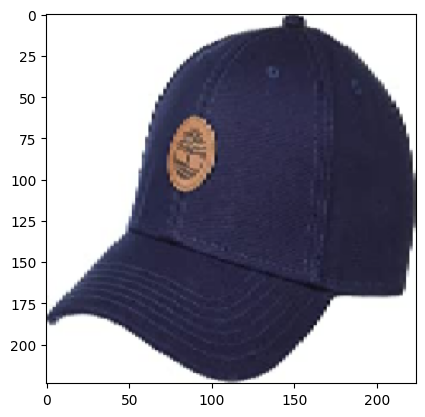

-----------------------------------------------------------------------
most similar products:


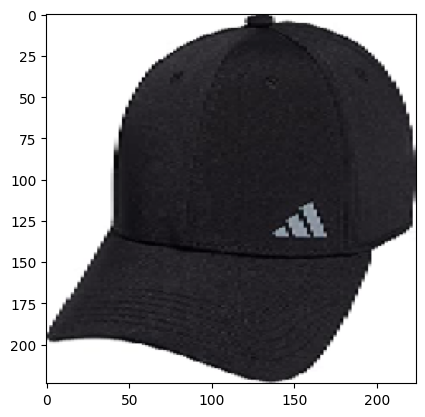

similarity score :  0.87655413


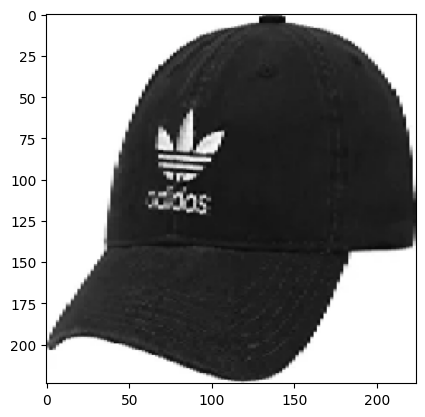

similarity score :  0.8698091


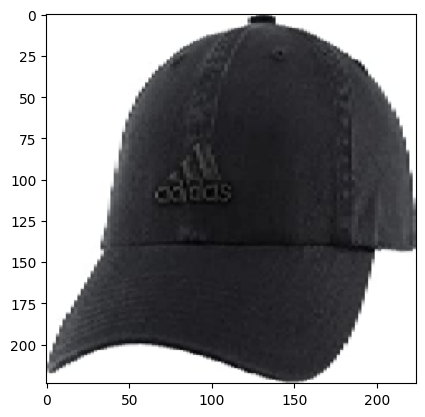

similarity score :  0.84633565


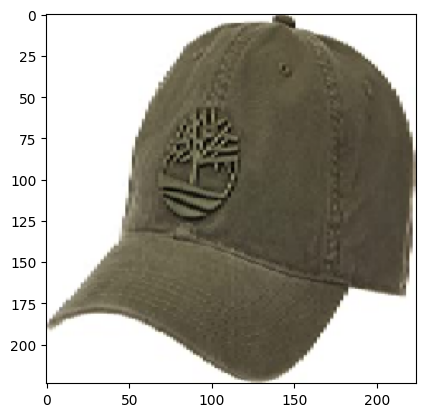

similarity score :  0.84339076


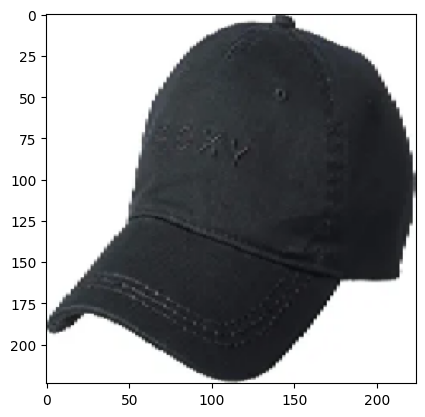

similarity score :  0.8393687


In [33]:
retrieve_most_similar_products(files[1])

-----------------------------------------------------------------------
original product:


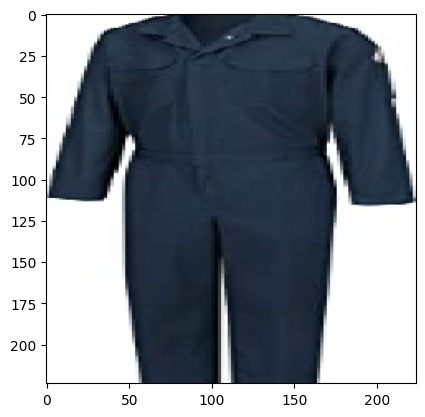

-----------------------------------------------------------------------
most similar products:


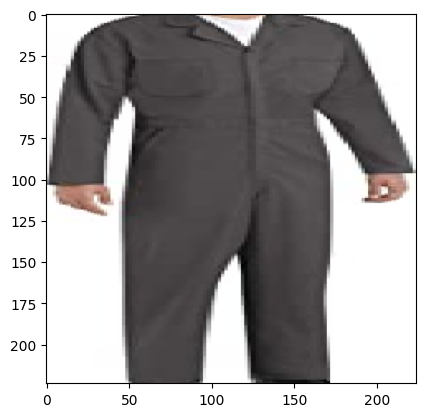

similarity score :  0.9019405


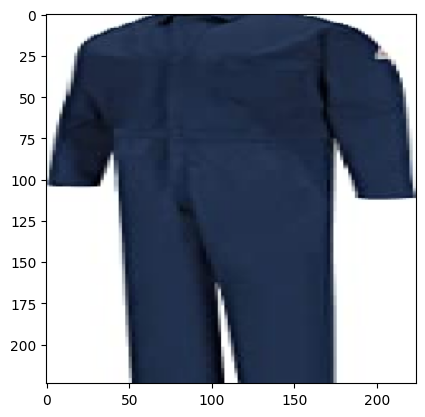

similarity score :  0.8790281


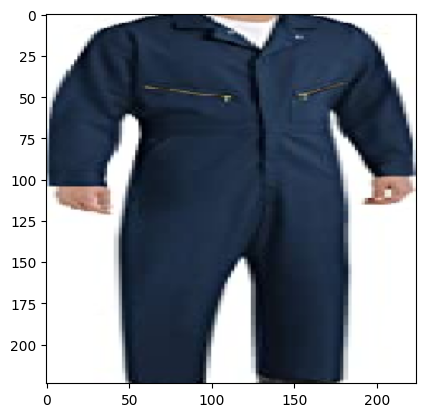

similarity score :  0.86631215


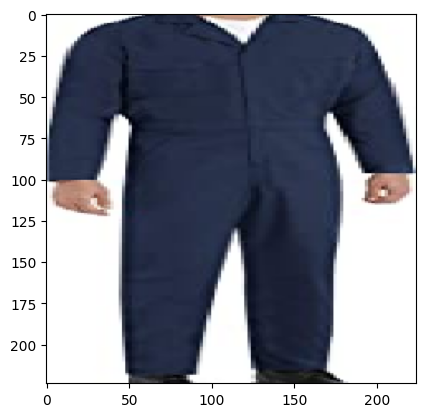

similarity score :  0.85717857


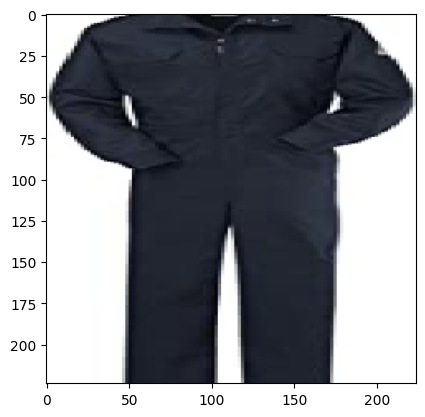

similarity score :  0.8423005


In [36]:
retrieve_most_similar_products(files[500])

-----------------------------------------------------------------------
original product:


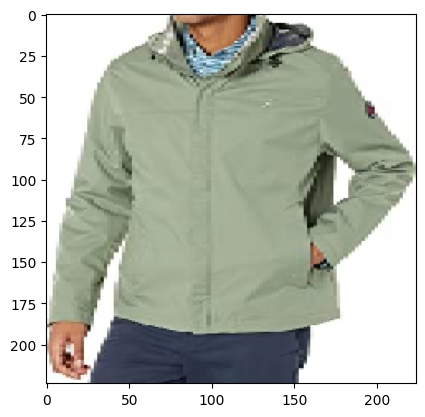

-----------------------------------------------------------------------
most similar products:


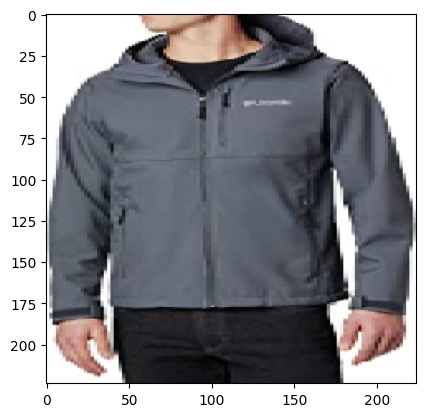

similarity score :  0.8591389


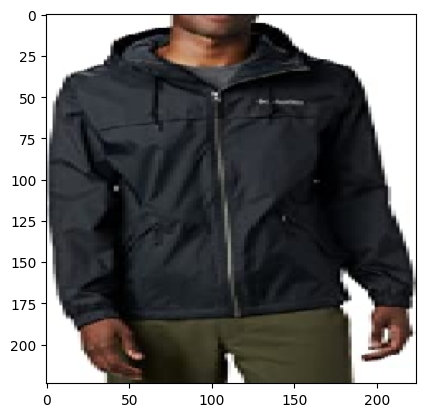

similarity score :  0.8483013


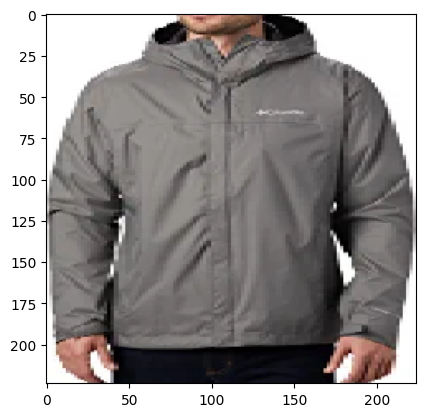

similarity score :  0.8198071


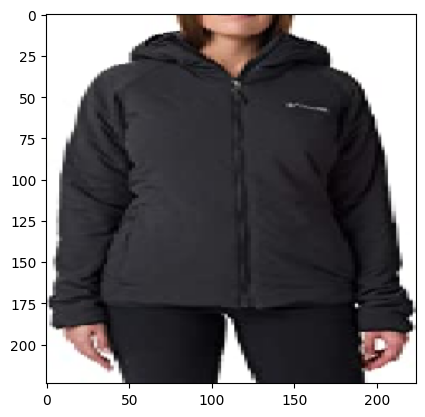

similarity score :  0.81464607


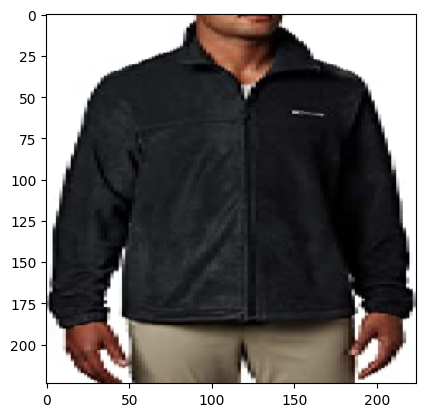

similarity score :  0.8123938


In [37]:
retrieve_most_similar_products(files[900])